### 2. Data Understanding

##### In this section, I will list the sources where the data can be found to support the analysis of the business problem we discussed in the previous section. And, I will take a look at the data to identify and understand the data a bit. Then I will move on to do wrangling the data to prepare that for extensive analysis.

##### Data Sources

1. Foursquare - is the major source of my analysis as it provides all the venues around the neighbourhoods. This source is capable of providing lot of additional information like ratings etc. but for this analysis, I will be focusing at the high level and using the appropriate level of data that can be obtained with a regular membership

2. Wiki - This is another lake of source. I will be using this to get the initial list such as zip/postal codes, boroughs etc.
    - Toronto Neighbourhood https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

3. Other sites - to get information like demographics etc.
    - NY City Zip https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/
    - NY Zipcode Mapping https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

In [125]:
pip install lxml

     |████████████████████████████████| 5.8MB 9.3MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [68]:
import pandas as pd
import requests # library to handle requests
import matplotlib as plt

#### New York Data

In [5]:
nyzipmap = pd.read_csv("NY City Zip Code Mapping.csv")

In [6]:
nyzipmap.shape

(42, 4)

In [7]:
nyzipmap.head()

,Borough,Neighbourhood,Zip,ZIP Codes
0,Bronx,Central Bronx,"10453, 10457, 10460",NaN
1,Bronx,Bronx Park and Fordham,"10458, 10467, 10468",NaN
2,Bronx,High Bridge and Morrisania,"10451, 10452, 10456",NaN
3,Bronx,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474",NaN
4,Bronx,Kingsbridge and Riverdale,"10463, 10471",NaN


 - The nyzipmap contains an unwanted column 'ZIP Codes' 
 - The 'Zip' column contains zip in a string concatenated format
 
 the above are to be cleaned

##### normalize the zip codes into multiple rows

In [8]:
nyzip = pd.DataFrame()
for index, row in nyzipmap.iterrows():
    for i in str.split(row['Zip'],','):
        borough = row['Borough']
        neigh = row['Neighbourhood']
        zipcode = i.strip()
        nyzip=nyzip.append([[borough, neigh, zipcode]])
nyzip.columns=['borough','neigh','zipcode']
nyzip.set_index('zipcode', drop=True, inplace=True)
nyzip.head()

,borough,neigh
zipcode,,
10453,Bronx,Central Bronx
10457,Bronx,Central Bronx
10460,Bronx,Central Bronx
10458,Bronx,Bronx Park and Fordham
10467,Bronx,Bronx Park and Fordham


In [9]:
nyzip.shape

(178, 2)

In [10]:
nyzip.dtypes

borough    object
neigh      object
dtype: object

##### Load the geo code file to get the lat and lng for the given zip codes

In [11]:
nygeo = pd.read_csv('NY_Zip_Geo.csv')

In [12]:
nygeo.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,14043,Depew,NY,42.904958,-78.700600,-5,1,42.904958
1,13827,Owego,NY,42.120274,-76.258740,-5,1,42.120274
2,14739,Friendship,NY,42.192384,-78.143080,-5,1,42.192384
3,11703,North Babylon,NY,40.733398,-73.322570,-5,1,40.733398
4,11707,West Babylon,NY,40.922326,-72.637078,-5,1,40.922326


In [13]:
nygeo.shape

(2281, 8)

In [14]:
#drop unnecessary columns
nygeo.drop(columns=['State','Timezone','Daylight savings time flag','geopoint'], inplace=True)

In [15]:
nygeo.dtypes

Zip            int64
City          object
Latitude     float64
Longitude    float64
dtype: object

In [16]:
#the zip code column name and the data type to be updated
nygeo.rename(columns={'Zip':'zipcode'}, inplace=True)
nygeo['zipcode']=nygeo['zipcode'].apply(str)
nygeo.set_index('zipcode', drop=True, inplace=True)

In [17]:
nygeo.dtypes

City          object
Latitude     float64
Longitude    float64
dtype: object

In [27]:
nyneigh = nygeo.join(nyzip[['borough','neigh']])

In [28]:
nyneigh.head()

,City,Latitude,Longitude,borough,neigh
zipcode,,,,,
14043,Depew,42.904958,-78.700600,NaN,NaN
13827,Owego,42.120274,-76.258740,NaN,NaN
14739,Friendship,42.192384,-78.143080,NaN,NaN
11703,North Babylon,40.733398,-73.322570,NaN,NaN
11707,West Babylon,40.922326,-72.637078,NaN,NaN


##### there are several NaN rows which we can remove

In [29]:
nyneigh.borough.value_counts()

Queens           61
Manhattan        40
Brooklyn         37
Bronx            25
Staten Island    12
Name: borough, dtype: int64

In [30]:
# removing NaN rows
nyneigh = nyneigh.dropna()
nyneigh.head()

,City,Latitude,Longitude,borough,neigh
zipcode,,,,,
10001,New York,40.750742,-73.99653,Manhattan,Chelsea and Clinton
10002,New York,40.717040,-73.98700,Manhattan,Lower East Side
10003,New York,40.732509,-73.98935,Manhattan,Lower East Side
11417,Ozone Park,40.675534,-73.84476,Queens,Southwest Queens
11418,Richmond Hill,40.698485,-73.83365,Queens,Southwest Queens


In [32]:
nyneigh.reset_index('zipcode',inplace=True)

In [39]:
nyneigh.rename(columns={'zipcode':'Postcode','borough':'Borough', 'neigh':'Neighbourhood'}, inplace=True)

In [40]:
nyneigh.head()

,Postcode,City,Latitude,Longitude,Borough,Neighbourhood
0,10001,New York,40.750742,-73.99653,Manhattan,Chelsea and Clinton
1,10002,New York,40.717040,-73.98700,Manhattan,Lower East Side
2,10003,New York,40.732509,-73.98935,Manhattan,Lower East Side
3,11417,Ozone Park,40.675534,-73.84476,Queens,Southwest Queens
4,11418,Richmond Hill,40.698485,-73.83365,Queens,Southwest Queens


#### Toronto Data

In [58]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df=pd.read_html(url, header=0)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


##### There are several unassigned neighbourhoods. remove unassigned neighbourhoods

In [59]:
df = df[df['Borough']!='Not assigned']

##### Fixing 'Not assigned' Neighbourhoods - If the 'Neighbourhood' contains value 'Not assigned' then use the value from 'Borough'

In [60]:
df['Neighbourhood'] = [row['Borough'] if row['Neighbourhood']=='Not assigned' else row['Neighbourhood'] for index, row in df.iterrows()]

In [61]:
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


##### Consolidating Neighbourhoods - There are more than one neighbourhoods for Postcode and Borough combination. in such cases, the neighbourhood values to be concatenated into a single row

In [62]:
#combining the neighbourhood 
df['Neighbourhood'] = df[['Postcode','Borough', 'Neighbourhood']].groupby(['Postcode','Borough'])['Neighbourhood'].transform(lambda x : ', '.join(x))
df.drop_duplicates()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,"Lawrence Heights, Lawrence Manor"
7,M7A,Downtown Toronto,Queen's Park
...,...,...,...
254,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
261,M4Y,Downtown Toronto,Church and Wellesley
264,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern
265,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So..."


In [63]:
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,"Lawrence Heights, Lawrence Manor"
6,M6A,North York,"Lawrence Heights, Lawrence Manor"


#### geocoder not seem to be working so using the prebuilt csv file

In [64]:
geo = pd.read_csv('TO_Postal_Geo.csv')
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [65]:
df = df.join(geo.set_index('Postal Code'), on='Postcode')

In [66]:
toneigh = df

In [67]:
toneigh.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
6,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763


In [68]:
toneigh.shape

(210, 5)

#### Getting Venue data for NY and TO using Foursquare

In [43]:
# @hidden_cell
#credentials from Foursquare
CLIENT_ID='VX13V3SLZUC3QSTZEB10QYJYV2YHN1UJ40UQWFL5AGPS2T3N'
CLIENT_SECRET='MZSBCYJZBNKMSHA1GW4H1FWILQZKIFWOXTZKTVNQW4DZJLQ1'

In [44]:
# assign key values 
VERSION = '20180604'
LIMIT = 10
creds = [CLIENT_ID,CLIENT_SECRET,VERSION]

In [45]:
def explore_borough(df, creds, radius, limit):
    
    clientid = creds[0]
    clientsec = creds[1]
    version = creds[2]
    
    venuelevelres = []
    venue_info = []
    
    df_venue_info = pd.DataFrame()
    
    for index, row in df.iterrows():
        postcode = row['Postcode']
        neighbourhood = row['Neighbourhood']
        borough = row['Borough']
        lat = row['Latitude']
        lng = row['Longitude']
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            clientid, 
            clientsec, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
        response = requests.get(url).json()
        # get the details at the venue level from the response.
        # item level information,in turn will have category level information which will be looped through
        
        # we need the result at category level. so first get the venue level list and then loop through the list to get the category level info
        # results['response']['groups'][0]['items'][0]['venue']['categories'][0]['name']
        venuelevelres = response['response']['groups'][0]['items']
        for v in venuelevelres:
            venuename = v['venue']['name']
            venuelat = v['venue']['location']['lat']
            venuelng = v['venue']['location']['lng']
            venuecat = v['venue']['categories'][0]['name']
            #append the current venue details to the list. finally this will have all the venues for a boroguh
            venue_info.append([neighbourhood, postcode, borough, lat, lng, venuename, venuelat, venuelng, venuecat])
        
    df_venue_info = pd.DataFrame(venue_info, columns = ['neighbourhood','postcode','borough','lat','lng','venue','vlat','vlng','vcat'])
    return df_venue_info

In [52]:
radius_in_meters=500
limit_of_results_found=100

##### Get New York venues

In [3]:
#get the NY venues

#ny_venues = explore_borough(nyneigh, creds, radius_in_meters, limit_of_results_found)
ny_venues = pd.read_csv('ny_venues.csv', index_col=0)

In [4]:
ny_venues.head()

,neighbourhood,postcode,borough,lat,lng,venue,vlat,vlng,vcat
0,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,You Should Be Dancing…..! / Club 412,40.750306,-73.994743,Dance Studio
1,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
2,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,Music Choice,40.752632,-73.994585,Music Venue
3,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,Madison Square Garden,40.750752,-73.993542,Basketball Stadium
4,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,Bluestone Lane,40.752254,-73.998824,Coffee Shop


In [5]:
ny_venues.shape

(7405, 9)

In [96]:
#export the results to save Foursquare usage :P
#ny_venues.to_csv('ny_venues.csv')

##### Get Toronto venues

In [6]:
#get the TO venues

#to_venues = explore_borough(toneigh, creds, radius_in_meters, limit_of_results_found)
to_venues = pd.read_csv('to_venues.csv', index_col=0)

In [7]:
to_venues.head()

,neighbourhood,postcode,borough,lat,lng,venue,vlat,vlng,vcat
0,Parkwoods,M3A,North York,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,M3A,North York,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,M3A,North York,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
3,Victoria Village,M4A,North York,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,M4A,North York,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [8]:
to_venues.shape

(4286, 9)

In [75]:
#export the results to save Foursquare usage :P
#to_venues.to_csv('to_venues.csv')

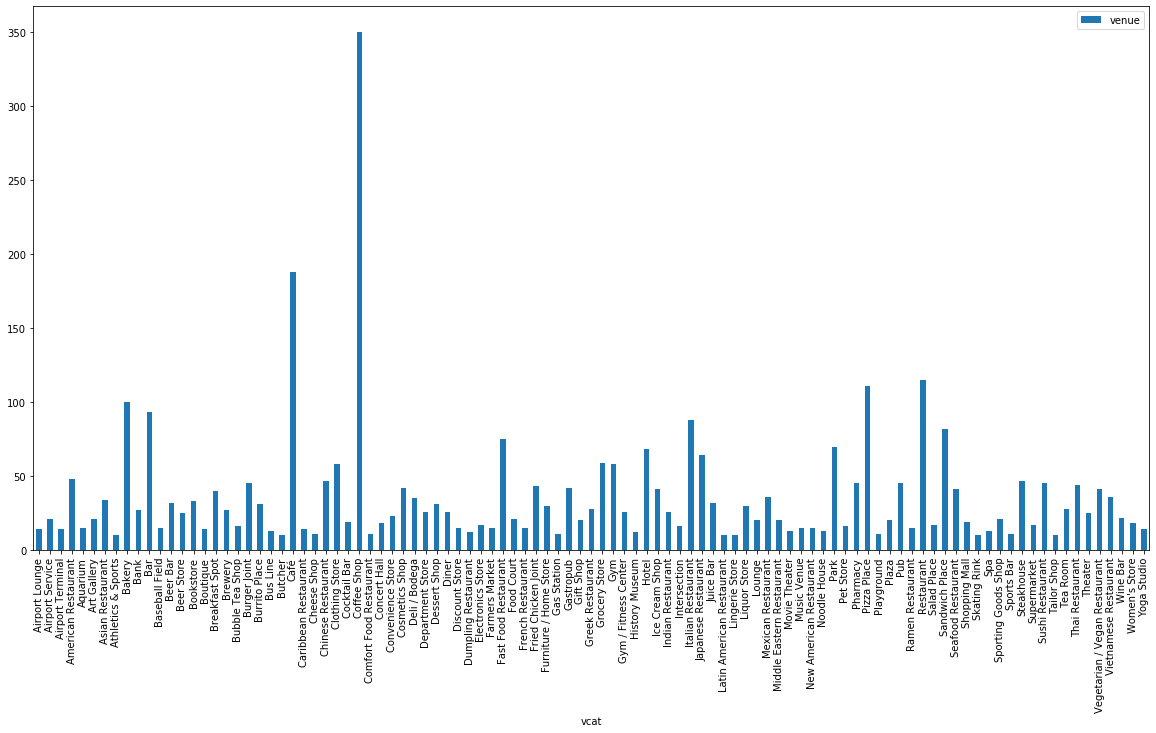

In [75]:
to_vcat_grp = to_venues[['vcat','venue']].groupby(by='vcat').count()
to_vcat_grp[to_vcat_grp['venue']>=10].plot(kind='bar', figsize=[20, 10])

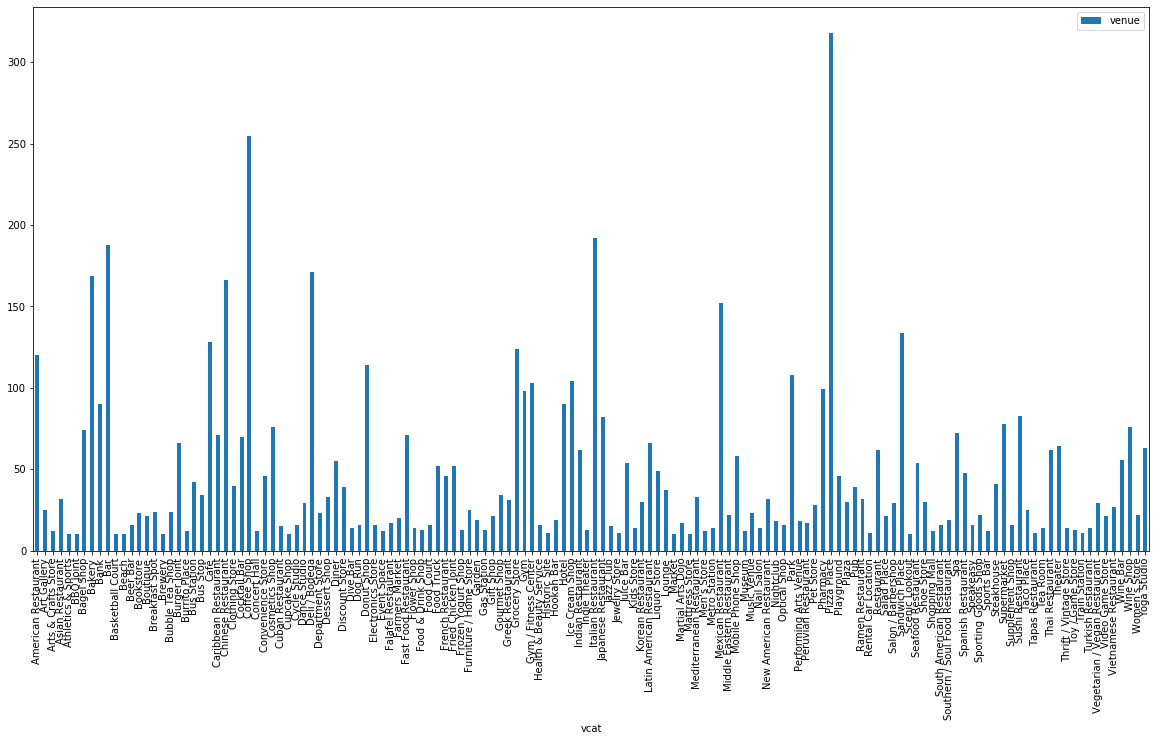

In [76]:
ny_vcat_grp = ny_venues[['vcat','venue']].groupby(by='vcat').count()
ny_vcat_grp[ny_vcat_grp['venue']>=10].plot(kind='bar', figsize=[20, 10])

#### As seen in the above plots, there are several venues exists in both Toronto and New York....and of course there are more venues in NY than TO. lets expore the data further in the next section